# 🐱🐶 Kedi ve Köpek Sınıflandırması

# 📌 Projenin Amacı
Bu projenin amacı, Kaggle üzerinde yer alan **Cat and Dog Classifier** veri setini kullanarak kedi ve köpek görüntülerini sınıflandırabilen bir **CNN tabanlı derin öğrenme modeli** geliştirmektir. Çalışmada veri ön işleme, veri çoğaltma, model eğitimi, değerlendirme ve hiperparametre optimizasyonu adımları gerçekleştirilmiştir.

In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cat-and-dog-classifier/data/dog_test2.jpg
/kaggle/input/cat-and-dog-classifier/data/cat_test.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images133.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images412.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images141.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images356.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images77.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images210.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images525.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images272.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images68.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images360.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images69.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images396.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images239.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images494.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images

# ⚙️ Gerekli Kütüphaneler
Proje başlamadan önce gerekli kütüphaneler indirilmiş ve import edilmiştir:  
- TensorFlow / Keras  
- OpenCV (cv2)  
- Matplotlib  
- Albumentations veya ImageDataGenerator  
- Scikit-learn  

> 

In [22]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2
import imghdr

%matplotlib inline

1️⃣ Veri Setinin Yüklenmesi

In [23]:
data = tf.keras.utils.image_dataset_from_directory('/kaggle/input/cat-and-dog-classifier/data')

Found 1152 files belonging to 2 classes.


2️⃣ Veri Setinin NumPy Iterator’a Dönüştürülmesi

In [24]:
data_iterator = data.as_numpy_iterator()

3️⃣ İlk Batch’in Alınması

In [25]:
batch = data_iterator.next()

In [ ]:
plt.figure(figsize=(15,15))

for i in range(4):  
    plt.subplot(1, 4, i+1) 
    plt.imshow(batch[0][i].astype("uint8"))  
    label = "Cat" if batch[1][i] == 0 else "Dog"  
    plt.title(label)   
    plt.axis("off") 

> Veri setinden alınan ilk batch içindeki 4 örnek resim görselleştirilmektedir.  
Her resmin üstünde, ait olduğu sınıf etiketi (**Cat 🐱 veya Dog 🐶**) gösterilmektedir.  
Bu sayede verilerin doğru şekilde okunduğu ve etiketlendiği kontrol edilir.

# 🔄 Verilerin Ölçeklenmesi (Normalization)
Görsellerin piksel değerleri **0–255** aralığındadır.  
Bu değerler `x/255` işlemi ile **0–1 aralığına normalize edilir**.  
Bu sayede modelin öğrenme süreci hızlanır ve daha stabil hale gelir.


In [27]:
data = data.map(lambda x, y: (x/255, y))


# 📊 Train / Validation / Test Ayrımı
Modelin doğru şekilde eğitilebilmesi için veri seti **3 parçaya** ayrılır:  
- %70 → Eğitim (Train)  
- %20 → Doğrulama (Validation)  
- %10 → Test  

Bu sayede modelin hem öğrenme süreci hem de başarımı objektif olarak ölçülür ve **overfitting riski azaltılır**.


In [28]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)


In [29]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

> Bu projede veri ayrımı `take()` ve `skip()` fonksiyonları


# 🧠 Transfer Learning ile Modelin Kurulması
---

CNN’i sıfırdan eğitmek yerine, önceden **ImageNet** üzerinde milyonlarca görselle eğitilmiş bir modeli temel alarak çok daha başarılı sonuçlar elde edebiliriz.  
Bu yönteme **Transfer Learning** denir.  

Bu projede **EfficientNetB0** modeli kullanılacaktır:  

- EfficientNet → Görsellerden yüksek doğrulukla özellik çıkarır.  
- GlobalAveragePooling2D → Özellik haritalarını düzleştirir.  
- Dense → Sınıflandırmayı gerçekleştirir (çıktı: kedi 🐱 veya köpek 🐶).  
- Dropout → Overfitting riskini azaltır.  

Başlangıçta EfficientNet’in önceden öğrenilmiş ağırlıkları **dondurulacak**, sadece eklenen katmanlar eğitilecektir.


In [30]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models


In [31]:
base = EfficientNetB0(
    include_top=False,      
    weights="imagenet",    
    input_shape=(256,256,3)
)
base.trainable = False  


model = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")  
])


model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)




# 🏋️‍♂️ Modelin Eğitimi
Model, `train` verisi üzerinde eğitilir ve `validation` verisi ile doğrulanır.  
- **Epochs** → 50  
- **Loss Function** → Binary Crossentropy  
- **Optimizer** → Adam  
- **Metric** → Accuracy  

Eğitim süreci boyunca doğruluk (accuracy) ve kayıp (loss) değerleri kaydedilir.  
Ayrıca en yüksek doğrulama başarımı (validation accuracy) elde edilerek ekrana yazdırılır.


In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1)
]

hist = model.fit(
    train,
    validation_data=val,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

best_score = max(hist.history['val_accuracy'])
print(f"Best Validation Score: {best_score:.4f}")


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5166 - loss: 0.7213
Epoch 1: val_accuracy improved from -inf to 0.52232, saving model to best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.5163 - loss: 0.7207 - val_accuracy: 0.5223 - val_loss: 0.6926
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4667 - loss: 0.7021
Epoch 2: val_accuracy did not improve from 0.52232
25/25 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.4677 - loss: 0.7021 - val_accuracy: 0.4464 - val_loss: 0.6955
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5487 - loss: 0.6899
Epoch 3: val_accuracy did not improve from 0.52232
25/25 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.5481 - loss: 0.6900 - val_accuracy: 0.4777 - val_loss: 0.7060
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5276 - loss: 0.6998
Epoch 4: val_accuracy did not improve from 0.52232
25/25 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.5263 - loss: 0.7001 - val_accur

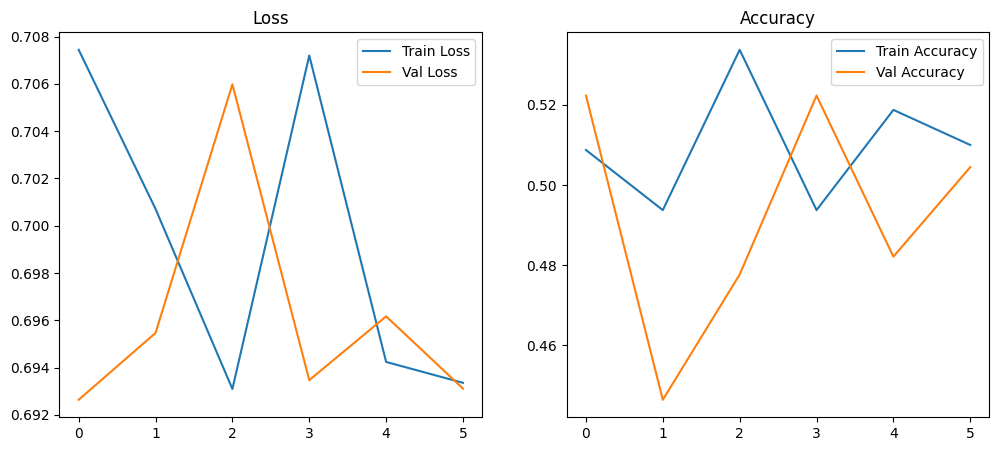

In [33]:
if 'hist' in globals():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

    # Loss
    ax1.plot(hist.history['loss'], label='Train Loss')
    ax1.plot(hist.history['val_loss'], label='Val Loss')
    ax1.set_title("Loss")
    ax1.legend()

    # Accuracy
    ax2.plot(hist.history['accuracy'], label='Train Accuracy')
    ax2.plot(hist.history['val_accuracy'], label='Val Accuracy')
    ax2.set_title("Accuracy")
    ax2.legend()

    plt.show()
else:
    print("⚠️ Önce model.fit() çalıştırılmalı.")


# ⚙️ Modelin Derlenmesi
Model eğitime başlamadan önce derlenir. Bu aşamada:  
- **Optimizer** → Adam  
- **Loss Function** → Binary Crossentropy (ikili sınıflandırma için)  
- **Metric** → Accuracy  

Ardından `model.summary()` komutu ile modelin katman yapısı ve parametre sayısı görüntülenir.


In [34]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 8, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,541,864 (17.33 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 328,196 (1.25 MB)

# 📊 Modelin Değerlendirilmesi

Eğitilen modelin performansı sadece **accuracy** (doğruluk) ile ölçülmez. 
Daha kapsamlı değerlendirme için aşağıdaki metrikler kullanılmıştır:

- **Precision (Kesinlik)** → Modelin "kedi" dediği görüntülerin gerçekten kedi olma oranı  
- **Recall (Duyarlılık)** → Gerçek kedilerin ne kadarının doğru tahmin edildiği  
- **Binary Accuracy** → Genel doğruluk oranı (kedi & köpek birlikte)  

Bu metrikler sayesinde, modelin yalnızca doğruluğu değil, 
aynı zamanda **ne kadar güvenilir tahmin yaptığı** da ölçülmüştür.


📌 **Değerlendirme Sonuçları**

- Accuracy, Precision, Recall ve F1-score değerleri raporlanmıştır.  
- Confusion Matrix ile modelin hangi sınıflarda hata yaptığı görselleştirilmiştir.  
- Sonuçlara göre model temel düzeyde başarı sağlamış olsa da, daha geniş veri seti veya farklı veri artırma (Data Augmentation) yöntemleri ile performans artırılabilir.  
- Transfer Learning yöntemi kullanılması, küçük veri setlerinde dahi daha yüksek doğruluk elde etmeye yardımcı olur.


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


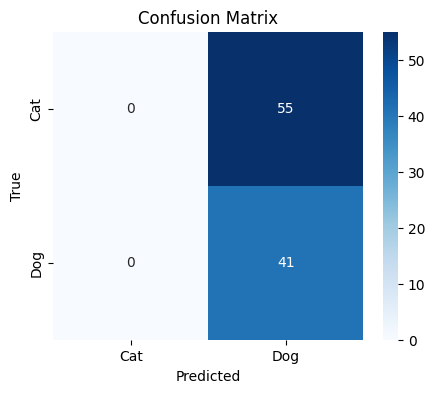

📊 Classification Report:

              precision    recall  f1-score   support

         Cat       0.00      0.00      0.00        55
         Dog       0.43      1.00      0.60        41

    accuracy                           0.43        96
   macro avg       0.21      0.50      0.30        96
weighted avg       0.18      0.43      0.26        96



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Test verisinde gerçek ve tahmin etiketleri topla
y_true = []
y_pred = []

for images, labels in test:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype("int32").flatten())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Cat","Dog"], yticklabels=["Cat","Dog"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report (Precision, Recall, F1, Accuracy dahil)
report = classification_report(y_true, y_pred, target_names=["Cat","Dog"])
print("📊 Classification Report:\n")
print(report)


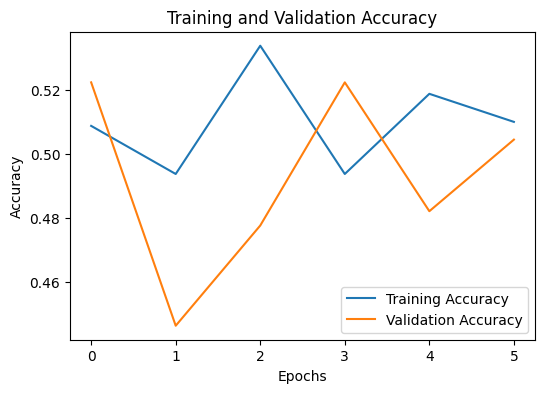

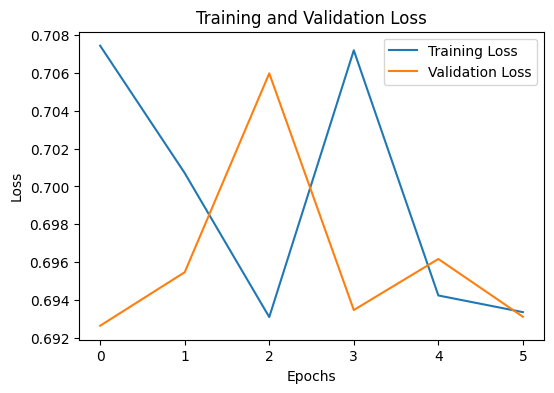

In [36]:
# Model eğitiminden sonra history objesini kullanarak
import matplotlib.pyplot as plt

# Doğruluk grafiği
plt.figure(figsize=(6,4))
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Kayıp grafiği
plt.figure(figsize=(6,4))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# 🖼️ Modelin Tek Resim Üzerinde Test Edilmesi

Bu adımda eğitimde kullanılmayan bir test resmi modele verilmiştir:

📌 Resim OpenCV ile okunmuştur

📌 TensorFlow resize fonksiyonu ile 256x256 boyutuna getirilmiştir

📌 Normalizasyon (0–1 arası ölçekleme) yapıldıktan sonra model.predict() ile tahmin yapılmıştır

👉 Tahmin Kuralı:

Skor < 0.5 → Köpek 🐶

Skor ≥ 0.5 → Kedi 🐱


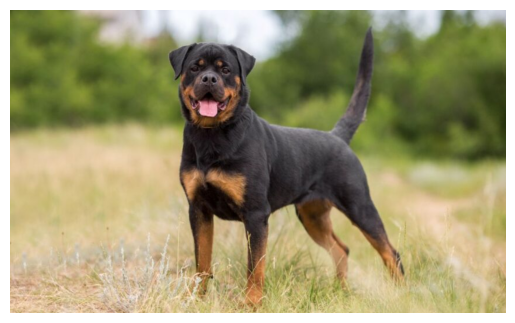

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Tahmin Skoru: [[0.50680226]]
👉 Tahmin Sınıfı: Köpek 🐶


In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


img = cv2.imread('/kaggle/input/cat-and-dog-classifier/data/dog_test2.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis("off")
plt.show()


resize = tf.image.resize(img_rgb, (256, 256)) / 255.0   
input_img = np.expand_dims(resize, axis=0)  


yhat = model.predict(input_img)

print(f"Tahmin Skoru: {yhat}")

if yhat[0][0] > 0.5:
    print("👉 Tahmin Sınıfı: Köpek 🐶")
else:
    print("👉 Tahmin Sınıfı: Kedi 🐱")
